### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import tree
from sklearn import neighbors
from sklearn import ensemble
from sklearn import svm
from sklearn import gaussian_process
from sklearn import naive_bayes
from sklearn import neural_network
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [5]:
testset = pd.read_csv("./test.csv")
trainset = pd.read_csv("./train.csv")
testset.head()

id  bone_length  rotting_flesh  hair_length  has_soul  color
0   3     0.471774       0.387937     0.706087  0.698537  black
1   6     0.427332       0.645024     0.565558  0.451462  white
2   9     0.549602       0.491931     0.660387  0.449809  black
3  10     0.638095       0.682867     0.471409  0.356924  white
4  13     0.361762       0.583997     0.377256  0.276364  black

### Show feature scatterplot

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


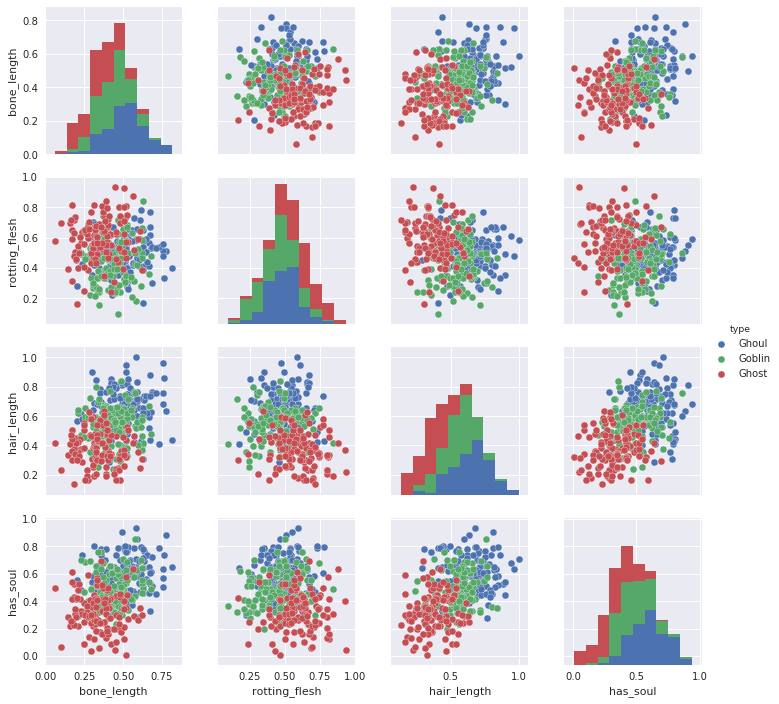

In [4]:
sns.set()
sns.pairplot(trainset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "type"]], hue="type")

### Creating additional features
It seems as if a combination of the features *has_soul* and *hair_length* can help us classify the monsters better. So therefor I will create an additional column which contains the product of these two.

In [6]:
trainset['hair_soul'] = trainset.apply(lambda row: row['hair_length']*row['has_soul'],axis=1)
trainset['hair_bone'] = trainset.apply(lambda row: row['hair_length']*row['bone_length'],axis=1)
trainset['bone_soul'] = trainset.apply(lambda row: row['bone_length']*row['has_soul'],axis=1)
trainset['hair_soul_bone'] = trainset.apply(lambda row: row['hair_length']*row['has_soul']*row['bone_length'],axis=1)

testset['hair_soul'] = testset.apply(lambda row: row['hair_length']*row['has_soul'],axis=1)
testset['hair_bone'] = testset.apply(lambda row: row['hair_length']*row['bone_length'],axis=1)
testset['bone_soul'] = testset.apply(lambda row: row['bone_length']*row['has_soul'],axis=1)
testset['hair_soul_bone'] = testset.apply(lambda row: row['hair_length']*row['has_soul']*row['bone_length'],axis=1)

Let's analyse the new features in a pairplot.

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


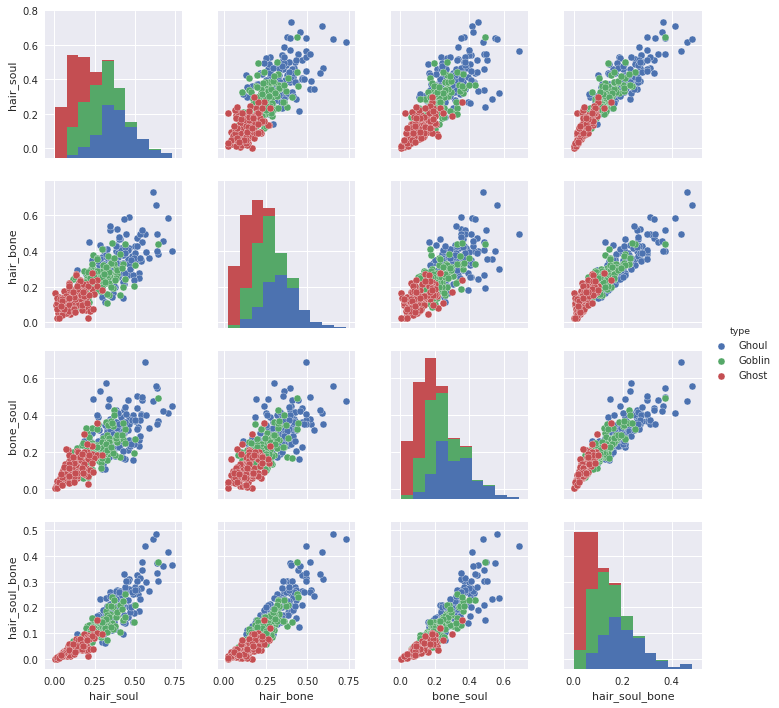

In [7]:
sns.set()
sns.pairplot(trainset[["hair_soul", "hair_bone", "bone_soul", "hair_soul_bone", "type"]], hue="type")

### Create dataframes
Selecting columns and onehot-encoding column "color". It seems that the color does not really help the predictions. So I left it out completely. Additionally I created two sets with the artificial features.

In [9]:
#x = pd.concat([trainset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul", "hair_bone", "bone_soul", "hair_soul_bone"]], pd.get_dummies(trainset["color"])], axis=1)
x = trainset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul", "hair_bone", "bone_soul", "hair_soul_bone"]]
x_original = trainset[["bone_length", "rotting_flesh", "hair_length", "has_soul"]]
x_hair_soul = trainset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul"]]
y = trainset[["type"]]
#x_test = pd.concat([testset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul", "hair_bone", "bone_soul", "hair_soul_bone"]], pd.get_dummies(testset["color"])], axis=1)
x_test = testset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul", "hair_bone", "bone_soul", "hair_soul_bone"]]
x_test_original = testset[["bone_length", "rotting_flesh", "hair_length", "has_soul"]]
x_test_hair_soul = testset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul"]]

### Creating set of classifiers

In [10]:
clfs = {}

#clfs['lr'] = {'clf': linear_model.LogisticRegression(), 'name':'LogisticRegression'}
#clfs['rf'] = {'clf': ensemble.RandomForestClassifier(n_estimators=750, n_jobs=-1), 'name':'RandomForest'}
clfs['tr'] = {'clf': tree.DecisionTreeClassifier(), 'name':'DecisionTree'}
#clfs['knn'] = {'clf': neighbors.KNeighborsClassifier(n_neighbors=4), 'name':'kNearestNeighbors'}
#clfs['svc'] = {'clf': svm.SVC(kernel='linear'), 'name': 'SupportVectorClassifier'}
clfs['nusvc'] = {'clf': svm.NuSVC(), 'name': 'NuSVC'}
clfs['linearsvc'] = {'clf': svm.LinearSVC(), 'name': 'LinearSVC'}
clfs['SGD'] = {'clf': linear_model.SGDClassifier(), 'name': 'SGDClassifier'}
clfs['GPC'] = {'clf': gaussian_process.GaussianProcessClassifier(), 'name': 'GaussianProcess'}
clfs['nb'] = {'clf': naive_bayes.GaussianNB(), 'name':'GaussianNaiveBayes'}
clfs['bag'] = {'clf': ensemble.BaggingClassifier(neighbors.KNeighborsClassifier(), max_samples=0.5, max_features=0.5), 'name': "BaggingClassifier"}
clfs['gbc'] = {'clf': ensemble.GradientBoostingClassifier(), 'name': 'GradientBoostingClassifier'}
#clfs['mlp'] = {'clf': neural_network.MLPClassifier(hidden_layer_sizes=(100,100,100), alpha=1e-5, solver='lbfgs', max_iter=500), 'name': 'MultilayerPerceptron'}

### Find the best parameters by usig GridSearch
Using GridSearch you can find the best parameters for a classifier. You just have to give an array for each parameter and GridSearch will try out every combination. That takes a lot longer to compute of course.

In [11]:
parameters = {'solver': ['lbfgs'], 'max_iter': [1500], 'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':np.arange(5, 12)}
clfs['mlpgrid'] = {'clf': GridSearchCV(neural_network.MLPClassifier(), parameters), 'name': 'MLP with GridSearch'}

parameters = {'kernel':['linear', 'sigmoid', 'poly', 'rbf'], 'gamma':np.linspace(0.0,2.0,num=21),'C': np.linspace(0.5,1.5,num=11)}
clfs['svcgrid'] = {'clf': GridSearchCV(svm.SVC(), parameters), 'name': 'SVC with GridSearch'}

parameters = {'n_estimators':np.arange(64, 1024, step=64)}
clfs['rfgrid'] = {'clf': GridSearchCV(ensemble.RandomForestClassifier(), parameters), 'name': 'Random Forest with GridSearch'}

parameters = {'n_neighbors':np.arange(3, 12)}
clfs['knngrid'] = {'clf': GridSearchCV(neighbors.KNeighborsClassifier(), parameters), 'name': 'KNN with GridSearch'}

parameters = {'n_estimators':np.arange(3, 12)}
clfs['adagrid'] = {'clf': GridSearchCV(ensemble.AdaBoostClassifier(), parameters), 'name': 'AdaBoost with GridSearch'}

parameters = {'C':[1],'tol':[0.0001],'solver': ['newton-cg'], 'multi_class': ['multinomial']}
clfs['lrgrid'] = {'clf': GridSearchCV(linear_model.LogisticRegression(), parameters), 'name': 'LogisticRegression with GridSearch'}

### Scoring classifiers with cross validation
I tried using artificial features here, but in most cases that did not lead to an improvement of the score. To save some computing time I commented the lines out.

In [12]:
for clf in clfs:
    clfs[clf]['score'] = cross_val_score(clfs[clf]['clf'], x_original, y.values.ravel(), cv=5)
    print(clfs[clf]['name'] + ": %0.4f (+/- %0.4f)" % (clfs[clf]['score'].mean(), clfs[clf]['score'].std()*2))
    #clfs[clf]['score'] = cross_val_score(clfs[clf]['clf'], x, y.values.ravel(), cv=5)
    #print(clfs[clf]['name'] + " (with all artificial features): %0.4f (+/- %0.4f)" % (clfs[clf]['score'].mean(), clfs[clf]['score'].std()*2))
    clfs[clf]['score'] = cross_val_score(clfs[clf]['clf'], x_hair_soul, y.values.ravel(), cv=5)
    print(clfs[clf]['name'] + " (with hair_soul feature): %0.4f (+/- %0.4f)" % (clfs[clf]['score'].mean(), clfs[clf]['score'].std()*2))

DecisionTree: 0.6362 (+/- 0.0983)
DecisionTree (with hair_soul feature): 0.6364 (+/- 0.0950)
NuSVC: 0.7091 (+/- 0.1135)
NuSVC (with hair_soul feature): 0.7277 (+/- 0.0895)
LinearSVC: 0.7249 (+/- 0.1057)
LinearSVC (with hair_soul feature): 0.7303 (+/- 0.1095)
SGDClassifier: 0.7109 (+/- 0.1697)
SGDClassifier (with hair_soul feature): 0.6899 (+/- 0.1314)
GaussianProcess: 0.7330 (+/- 0.0799)
GaussianProcess (with hair_soul feature): 0.7276 (+/- 0.0626)
GaussianNaiveBayes: 0.7413 (+/- 0.0662)
GaussianNaiveBayes (with hair_soul feature): 0.7250 (+/- 0.0676)
BaggingClassifier: 0.7225 (+/- 0.0607)
BaggingClassifier (with hair_soul feature): 0.7168 (+/- 0.0447)
GradientBoostingClassifier: 0.7222 (+/- 0.0534)
GradientBoostingClassifier (with hair_soul feature): 0.7412 (+/- 0.0613)
MLP with GridSearch: 0.7521 (+/- 0.0815)
MLP with GridSearch (with hair_soul feature): 0.7358 (+/- 0.0529)
SVC with GridSearch: 0.7493 (+/- 0.0949)
SVC with GridSearch (with hair_soul feature): 0.7466 (+/- 0.0626)
Rand

### Create voting classifier with the best 3 models

In [13]:
# classifiers using the hair_soul feature
clfs['vote_hair_soul'] = {'clf': ensemble.VotingClassifier(estimators=[
            ('svcgrid', clfs['svcgrid']['clf']),
            ('lrgrid', clfs['lrgrid']['clf']),
            ('gbc', clfs['gbc']['clf'])
        ], voting='hard'), 'name': 'VotingClassifierHairSoul'}

# classifiers using the original features
clfs['vote'] = {'clf': ensemble.VotingClassifier(estimators=[
            ('svcgrid', clfs['svcgrid']['clf']),
            ('lrgrid', clfs['lrgrid']['clf']),
            ('nb', clfs['gbc']['clf'])
        ], voting='hard'), 'name': 'VotingClassifier'}

### Fitting classifiers using the whole training set
Fitting the voting classifier. I commented out the old code that was used to fit all classifiers to the complete trainingset. I am using the hair_soul artificial feature here.

In [14]:
#for clf in clfs:
#    clfs[clf]['clf'].fit(x, y.values.ravel())
    
clfs['vote_hair_soul']['clf'] = clfs['vote_hair_soul']['clf'].fit(x_hair_soul, y.values.ravel())
clfs['vote']['clf'] = clfs['vote']['clf'].fit(x_original, y.values.ravel())

### Create predictions

In [15]:
#for clf in clfs:
#    clfs[clf]['predictions'] = clfs[clf]['clf'].predict(x_test)
    
clfs['vote_hair_soul']['predictions'] = clfs['vote_hair_soul']['clf'].predict(x_test_hair_soul)
clfs['vote']['predictions'] = clfs['vote']['clf'].predict(x_test_original)

### Create submission file

In [ ]:
#for clf in clfs:
#    sub = pd.DataFrame(clfs[clf]['predictions'])
#    pd.concat([testset["id"],sub], axis=1).rename(columns = {0: 'type'}).to_csv("submission_" + clfs[clf]['name'] + ".csv", index=False)

sub = pd.DataFrame(clfs['vote_hair_soul']['predictions'])
pd.concat([testset["id"],sub], axis=1).rename(columns = {0: 'type'}).to_csv("submission_" + clfs['vote_hair_soul']['name'] + ".csv", index=False)

sub = pd.DataFrame(clfs['vote']['predictions'])
pd.concat([testset["id"],sub], axis=1).rename(columns = {0: 'type'}).to_csv("submission_" + clfs['vote']['name'] + ".csv", index=False)